In [1]:
import tensorflow as tf
import tensorflow_datasets as tfds
from tensorflow.keras.layers import Input, Conv2D, Flatten, Dense, Reshape, Conv2DTranspose, Lambda, Dropout
from tensorflow.keras.models import Model
import matplotlib.pyplot as plt
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.losses import binary_crossentropy
import tensorflow.keras.backend as K
from tensorflow.keras.losses import mean_squared_error
from tensorflow.keras import layers



In [2]:
ds1,ds2,ds3 = tfds.load('patch_camelyon:2.0.0',split=['train[:10%]','test[:3%]','validation[:3%]'],
                        data_dir = r'C:\Users\maria\OneDrive\Skrivebord\3. semester\Anvendt maskinlæring\Exam',
                        download=False,
                        shuffle_files=True)

In [3]:
#Konverterer en enkelt sample fra et datasæt til det format, der er nødvendigt for træning af en autoencoder.

def convert_sample(sample):
    image = sample['image']
    image = tf.image.convert_image_dtype(image, tf.float32)
    return image, image  # Returner billedet som både input og label



In [5]:
# Map and batch the datasets
train_dataset = ds1.map(convert_sample).batch(64)
validation_dataset = ds3.map(convert_sample).batch(64)
test_dataset = ds2.map(convert_sample).batch(64)


In [7]:
latent_dim = 128

# Encoder
encoder_input = Input(shape=(96, 96, 3), name='encoder_input')
x = Conv2D(512, (3, 3), activation='relu', padding='same', strides=2)(encoder_input)
x = Conv2D(256, (3, 3), activation='relu', padding='same', strides=2)(x)
x = Conv2D(128, (3, 3), activation='relu', padding='same', strides=2)(x)
x = Flatten()(x)

z_mean = Dense(latent_dim, name='z_mean')(x)
z_log_var = Dense(latent_dim, name='z_log_var')(x)

# Reparameterization trick to sample from the latent space
def sampling(args):
    z_mean, z_log_var = args
    batch = K.shape(z_mean)[0]
    dim = K.int_shape(z_mean)[1]
    epsilon = K.random_normal(shape=(batch, dim))
    return z_mean + K.exp(0.5 * z_log_var) * epsilon

z = layers.Lambda(sampling, output_shape=(latent_dim,), name='z')([z_mean, z_log_var])

# Encoder Model
encoder = Model(encoder_input, [z_mean, z_log_var, z], name='encoder')


# Decoder
latent_inputs = Input(shape=(latent_dim,), name='decoder_input')
x = Dense(12 * 12 * 16, activation='relu')(latent_inputs)
x = Reshape((12, 12, 16))(x)
x = Conv2DTranspose(128, (3, 3), activation='relu', padding='same', strides=2)(x)
x = Conv2DTranspose(256, (3, 3), activation='relu', padding='same', strides=2)(x)
x = Conv2DTranspose(512, (3, 3), activation='relu', padding='same', strides=2)(x)
decoded = Conv2D(3, (3, 3), activation='sigmoid', padding='same')(x)


# Decoder Model
decoder = Model(latent_inputs, decoded, name='decoder')

# VAE Model
outputs = decoder(encoder(encoder_input)[2])
vae = Model(encoder_input, outputs, name='vae')


In [8]:
# Loss function
reconstruction_loss = mean_squared_error(K.flatten(encoder_input), K.flatten(outputs))
reconstruction_loss *= 96 * 96 * 3
kl_loss = 1 + z_log_var - K.square(z_mean) - K.exp(z_log_var)
kl_loss = K.sum(kl_loss, axis=-1)
kl_loss *= -0.5
vae_loss = K.mean(reconstruction_loss + kl_loss)

In [9]:
vae.add_loss(vae_loss)
vae.compile(optimizer='adam')


In [10]:
# Training
history = vae.fit(train_dataset, epochs=10, validation_data=validation_dataset)


Epoch 1/10
410/410 [==============================] - 3671s 9s/step - loss: 1091.8939 - val_loss: 1090.1494
Epoch 2/10
410/410 [==============================] - 3679s 9s/step - loss: 981.4935 - val_loss: 1041.6477
Epoch 3/10
410/410 [==============================] - 3660s 9s/step - loss: 952.5209 - val_loss: 1023.1996
Epoch 4/10
410/410 [==============================] - 3654s 9s/step - loss: 941.5808 - val_loss: 1014.9970
Epoch 5/10
410/410 [==============================] - 3668s 9s/step - loss: 923.5389 - val_loss: 984.2645
Epoch 6/10
410/410 [==============================] - 3665s 9s/step - loss: 905.4384 - val_loss: 982.7580
Epoch 7/10
410/410 [==============================] - 3020s 7s/step - loss: 899.9253 - val_loss: 969.8447
Epoch 8/10
410/410 [==============================] - 3019s 7s/step - loss: 896.8595 - val_loss: 965.5977
Epoch 9/10
410/410 [==============================] - 3187s 8s/step - loss: 891.2207 - val_loss: 964.0318
Epoch 10/10
410/410 [====================

In [11]:
import os
os.environ['KMP_DUPLICATE_LIB_OK'] = 'TRUE'



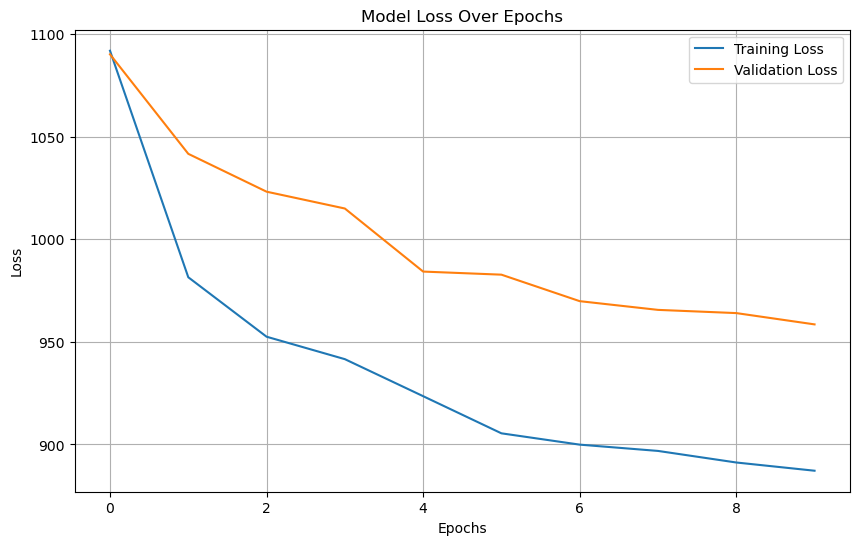

In [12]:
def plot_loss(history):
    plt.figure(figsize=(10, 6))
    plt.plot(history.history['loss'], label='Training Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.title('Model Loss Over Epochs')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.grid(True)
    plt.show()

plot_loss(history)

In [14]:
import os
os.environ['KMP_DUPLICATE_LIB_OK'] = 'TRUE'



In [15]:
def plot_reconstructions(vae, dataset, num_images=5):
    # Hent nogle eksempler fra datasettet
    sample_images = next(iter(dataset))[0][:num_images]

    # Få autoencoderens rekonstruktioner
    reconstructed_images = vae.predict(sample_images)

    # Plot originaler og rekonstruktioner
    plt.figure(figsize=(15, 4))
    for i in range(num_images):
        # Originalbillede
        plt.subplot(2, num_images, i + 1)
        plt.imshow(sample_images[i])
        plt.title("Original")
        plt.axis("off")

        # Rekonstrueret billede
        plt.subplot(2, num_images, i + 1 + num_images)
        plt.imshow(reconstructed_images[i])
        plt.title("Rekonstruktion")
        plt.axis("off")

    plt.show()



In [16]:
import os
os.environ['KMP_DUPLICATE_LIB_OK'] = 'TRUE'



1/1 [==============================] - 1s 890ms/step


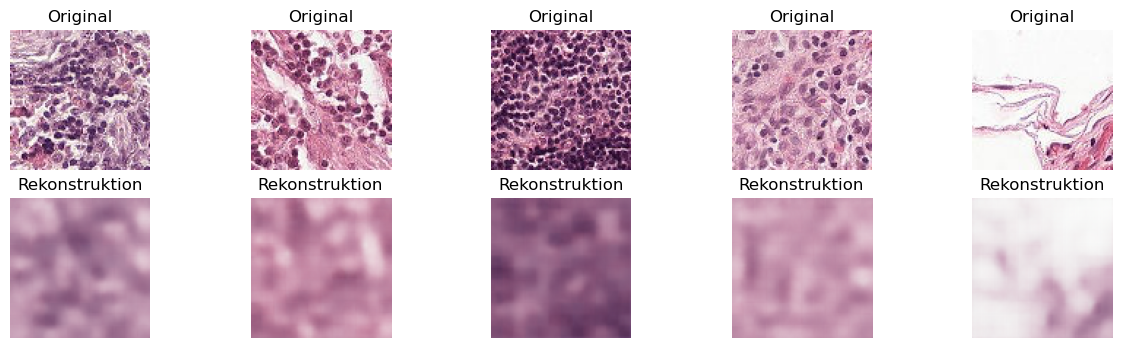

In [17]:
# Anvend funktionen på validationsættet
plot_reconstructions(vae, validation_dataset)

Beregning af Tab (Loss)

In [19]:
test_loss = vae.evaluate(test_dataset)
print("Test Loss (MSE):", test_loss)


16/16 [==============================] - 90s 6s/step - loss: 887.0505
Test Loss (MSE): 887.050537109375


In [20]:
import os
os.environ['KMP_DUPLICATE_LIB_OK'] = 'TRUE'



1/1 [==============================] - 2s 2s/step


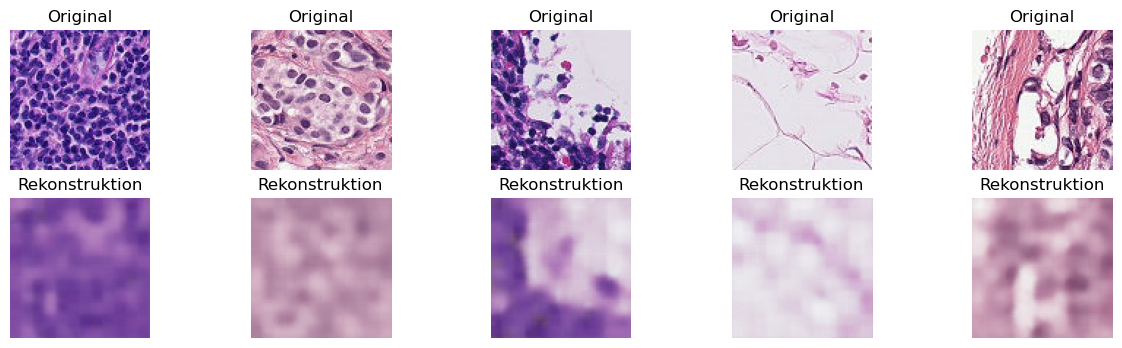

In [21]:
# Anvend funktionen på dit autoencoder-objekt og testdataset
plot_reconstructions(vae, test_dataset)

In [22]:
import os
os.environ['KMP_DUPLICATE_LIB_OK'] = 'TRUE'



In [32]:
# Forberedelse af datasæt til klassifikation
def prepare_classification_dataset(sample):
    image, label = sample['image'], sample['label']
    image = tf.image.convert_image_dtype(image, tf.float32)
    label = tf.one_hot(label, depth=2)  # Antager 2 klasser
    return image, label

In [33]:
# Map og batch datasæt
train_dataset_cls = ds1.map(prepare_classification_dataset).batch(32)
validation_dataset_cls = ds3.map(prepare_classification_dataset).batch(32)
test_dataset_cls = ds2.map(prepare_classification_dataset).batch(32)

In [34]:
# Skil data og labels ad
def extract_images_and_labels(dataset):
    images, labels = [], []
    for image_batch, label_batch in dataset:
        images.append(image_batch)
        labels.append(label_batch)
    return tf.concat(images, axis=0), tf.concat(labels, axis=0)

x_train, y_train = extract_images_and_labels(train_dataset_cls)
x_val, y_val = extract_images_and_labels(validation_dataset_cls)
x_test,y_test = extract_images_and_labels(test_dataset_cls)

In [57]:

# Få outputtet fra encoderen
encoder_output = encoder(encoder_input)

z_mean = encoder_output[0] if isinstance(encoder_output, list) else encoder_output

# Tilføj ekstra lag for klassifikation
x = Flatten()(z_mean)
x = Dense(256, activation='relu')(x)
x = Dropout(0.5)(x)
output = Dense(2, activation='softmax')(x)  # Antager binær klassifikation

# Byg hele modellen
classifier = Model(inputs=encoder_input, outputs=output)

# Kompiler klassifikatoren
classifier.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])


In [58]:

# Træn klassifikationsmodellen med mærket data
CNNmodel = classifier.fit(
    x_train, y_train, 
    epochs=10, 
    batch_size=32, 
    validation_data=(x_val, y_val)  
)


Epoch 1/10


820/820 [==============================] - 1949s 2s/step - loss: 0.5531 - accuracy: 0.7146 - val_loss: 0.4466 - val_accuracy: 0.7996
Epoch 2/10
820/820 [==============================] - 1889s 2s/step - loss: 0.4616 - accuracy: 0.7909 - val_loss: 0.4741 - val_accuracy: 0.7803
Epoch 3/10
820/820 [==============================] - 2366s 3s/step - loss: 0.4252 - accuracy: 0.8099 - val_loss: 0.4015 - val_accuracy: 0.8159
Epoch 4/10
820/820 [==============================] - 2295s 3s/step - loss: 0.3884 - accuracy: 0.8300 - val_loss: 0.4653 - val_accuracy: 0.7813
Epoch 5/10
820/820 [==============================] - 2219s 3s/step - loss: 0.3566 - accuracy: 0.8447 - val_loss: 0.4342 - val_accuracy: 0.8077
Epoch 6/10
820/820 [==============================] - 2241s 3s/step - loss: 0.3194 - accuracy: 0.8619 - val_loss: 0.5183 - val_accuracy: 0.7976
Epoch 7/10
820/820 [==============================] - 2213s 3s/step - loss: 0.2824 - accuracy: 0.8818 - val_loss: 0.4901 - val_accuracy: 0.7965
Epo

**Evaluering af Klassifikationsmodellen**

Nøjagtigheds- og Tabshistorik:

Plot nøjagtighed og tab over trænings- og valideringsdatasættene.

In [59]:
import os
os.environ['KMP_DUPLICATE_LIB_OK'] = 'TRUE'



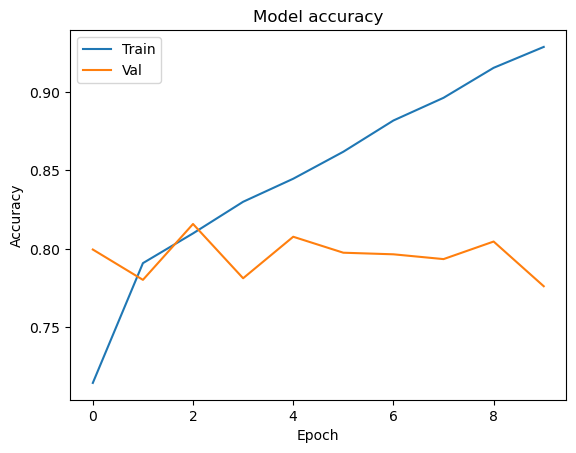

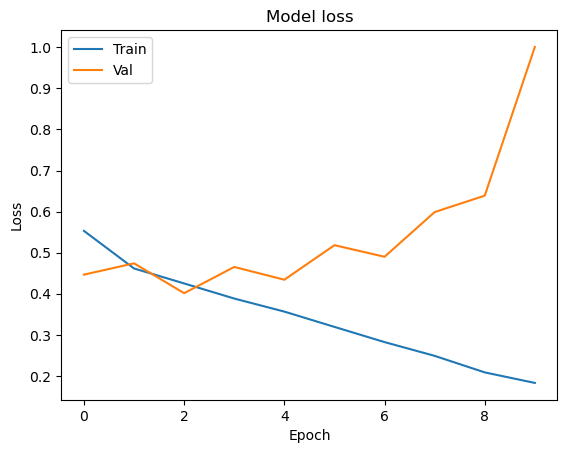

In [60]:
# Plot training & validation accuracy values
plt.plot(CNNmodel.history['accuracy'])
plt.plot(CNNmodel.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Val'], loc='upper left')
plt.show()

# Plot training & validation loss values
plt.plot(CNNmodel.history['loss'])
plt.plot(CNNmodel.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Val'], loc='upper left')
plt.show()

# Kald funktionen med historikken fra din klassifikationsmodel
# plot_history(classification_history)


Evaluering af Klassifikationsmodellen

In [61]:
import os
os.environ['KMP_DUPLICATE_LIB_OK'] = 'TRUE'



Confusionmatrix


In [66]:
# Evaluate Variational Autoencoder
mse_vae = vae.evaluate(validation_dataset)

print("MSE for Variational Autoencoder:", vae)

16/16 [==============================] - 107s 6s/step - loss: 2470.9927
MSE for Variational Autoencoder: <keras.engine.functional.Functional object at 0x00000202B1F99420>


In [ ]:
import os
os.environ['KMP_DUPLICATE_LIB_OK'] = 'TRUE'

In [67]:
def plot_reconstructions(vae, dataset, num_images=5):
    # Hent nogle eksempler fra datasettet
    sample_images = next(iter(dataset))[0][:num_images]

    # Få autoencoderens rekonstruktioner
    reconstructed_images = vae.predict(sample_images)

    # Plot originaler og rekonstruktioner
    plt.figure(figsize=(15, 4))
    for i in range(num_images):
        # Originalbillede
        plt.subplot(2, num_images, i + 1)
        plt.imshow(sample_images[i])
        plt.title("Original")
        plt.axis("off")

        # Rekonstrueret billede
        plt.subplot(2, num_images, i + 1 + num_images)
        plt.imshow(reconstructed_images[i])
        plt.title("Rekonstruktion")
        plt.axis("off")

    plt.show()



In [70]:
# Evaluate Variational Autoencoder
mse_vae = vae.evaluate(test_dataset)

print("MSE for Variational Autoencoder:", vae)

16/16 [==============================] - 104s 6s/step - loss: 2497.2869
MSE for Variational Autoencoder: <keras.engine.functional.Functional object at 0x00000202B1F99420>


In [73]:
from sklearn.metrics import confusion_matrix
import seaborn as sns

In [74]:
import os
os.environ['KMP_DUPLICATE_LIB_OK'] = 'TRUE'


In [75]:

def plot_confusion_matrix(model, x_data, y_true):
    y_pred = model.predict(x_data).argmax(axis=1)
    conf_mat = confusion_matrix(y_true.argmax(axis=1), y_pred)
    sns.heatmap(conf_mat, annot=True, fmt='d', cmap='Blues')
    plt.ylabel('True Label')
    plt.xlabel('Predicted Label')
    plt.show()


In [81]:
import os
os.environ['KMP_DUPLICATE_LIB_OK'] = 'TRUE'


31/31 [==============================] - 17s 413ms/step


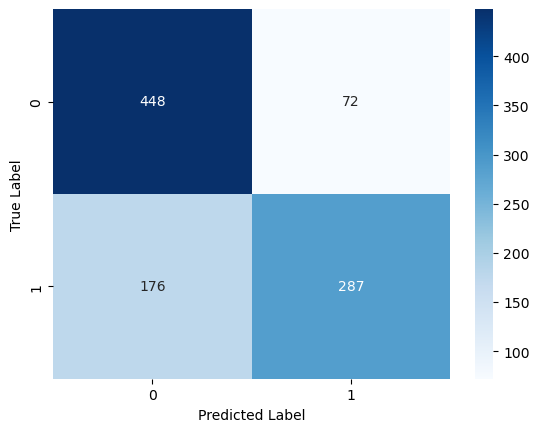

In [82]:
import numpy as np
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

def plot_confusion_matrix(model, x_data, y_true):
    y_pred = model.predict(x_data).argmax(axis=1)
    y_true = np.argmax(y_true, axis=1)  # Convert y_true to NumPy array
    conf_mat = confusion_matrix(y_true, y_pred)
    sns.heatmap(conf_mat, annot=True, fmt='d', cmap='Blues')
    plt.ylabel('True Label')
    plt.xlabel('Predicted Label')
    plt.show()

# Call the function
plot_confusion_matrix(classifier, x_test, y_test)


In [83]:
import os
os.environ['KMP_DUPLICATE_LIB_OK'] = 'TRUE'

31/31 [==============================] - 6s 173ms/step


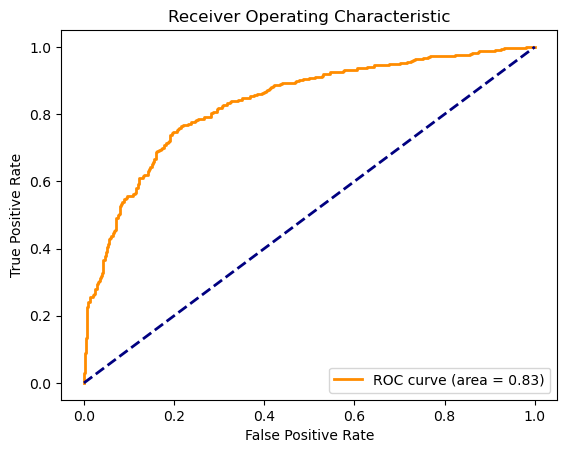

In [84]:
from sklearn.metrics import roc_curve, auc
import tensorflow as tf
import matplotlib.pyplot as plt

y_pred_prob = classifier.predict(x_test)[:, 1]  # Forudsigelse af sandsynligheder for klasse 1

# Brug tf.argmax til TensorFlow tensors og konverter til numpy array
y_true = tf.argmax(y_test, axis=1).numpy()

fpr, tpr, thresholds = roc_curve(y_true, y_pred_prob)
roc_auc = auc(fpr, tpr)

plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.show()